In [1]:
import os
# Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import iris

from utils import get_bc_ppe_data

from GCEm.nn_model import NNModel
from GCEm.utils import get_random_params

import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# Read in the parameters and data

In [3]:
ppe_params, ppe_aaod = get_bc_ppe_data()

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))


In [4]:
# Ensure the time dimension is last - this is treated as the color 'channel'
ppe_aaod.transpose((0,2,3,1))

In [5]:
n_test = 5

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
Y_test, Y_train = ppe_aaod[:n_test], ppe_aaod[n_test:]

In [6]:
Y_train

<iris 'Cube' of Absorption optical thickness - total 550nm / (1) (job: 34; latitude: 96; longitude: 192; time: 12)>

# Setup and run the models

In [7]:
nn_model = NNModel(X_train, Y_train)

In [8]:
nn_model.train()

Epoch 1/100
4/4 [==============================] - 0s 77ms/step - loss: 1.1407 - val_loss: 0.4611
Epoch 2/100
4/4 [==============================] - 0s 18ms/step - loss: 1.1368 - val_loss: 0.4616
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 1.1294 - val_loss: 0.4584
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 1.1180 - val_loss: 0.4592
Epoch 5/100
4/4 [==============================] - 0s 19ms/step - loss: 1.0970 - val_loss: 0.4534
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 1.0837 - val_loss: 0.4491
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 1.0528 - val_loss: 0.4385
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0250 - val_loss: 0.4318
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0007 - val_loss: 0.4203
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9637 - val_loss: 0.4335
Epoch 11/100
4/4 [=

In [9]:
nn_prediction, _ = nn_model.predict(X_test)

In [10]:
from GCEm.gp_model import GPModel
gp_model = GPModel(X_train, Y_train)
gp_model.train()

In [11]:
gp_prediction, _ = gp_model.predict(X_test.values)

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
 

Text(0.5,1,'Difference')

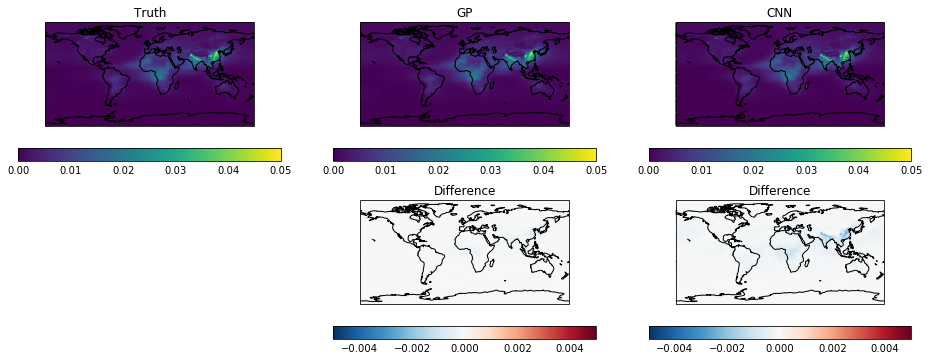

In [12]:
plt.figure(figsize=(16, 6))

plt.subplot(2,3,2)
qplt.pcolormesh(gp_prediction[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('GP')
plt.gca().coastlines()

plt.subplot(2,3,3)
qplt.pcolormesh(nn_prediction[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('CNN')
plt.gca().coastlines()

plt.subplot(2,3,1)
qplt.pcolormesh(Y_test[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('Truth')
plt.gca().coastlines()

plt.subplot(2,3,5)
qplt.pcolormesh((gp_prediction.collapsed(['sample', 'time'], iris.analysis.MEAN)-Y_test.collapsed(['job', 'time'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.005, vmax=0.005)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.subplot(2,3,6)
qplt.pcolormesh((nn_prediction.collapsed(['sample', 'time'], iris.analysis.MEAN)-Y_test.collapsed(['job', 'time'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.005, vmax=0.005)
plt.gca().coastlines()
plt.gca().set_title('Difference')

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
 

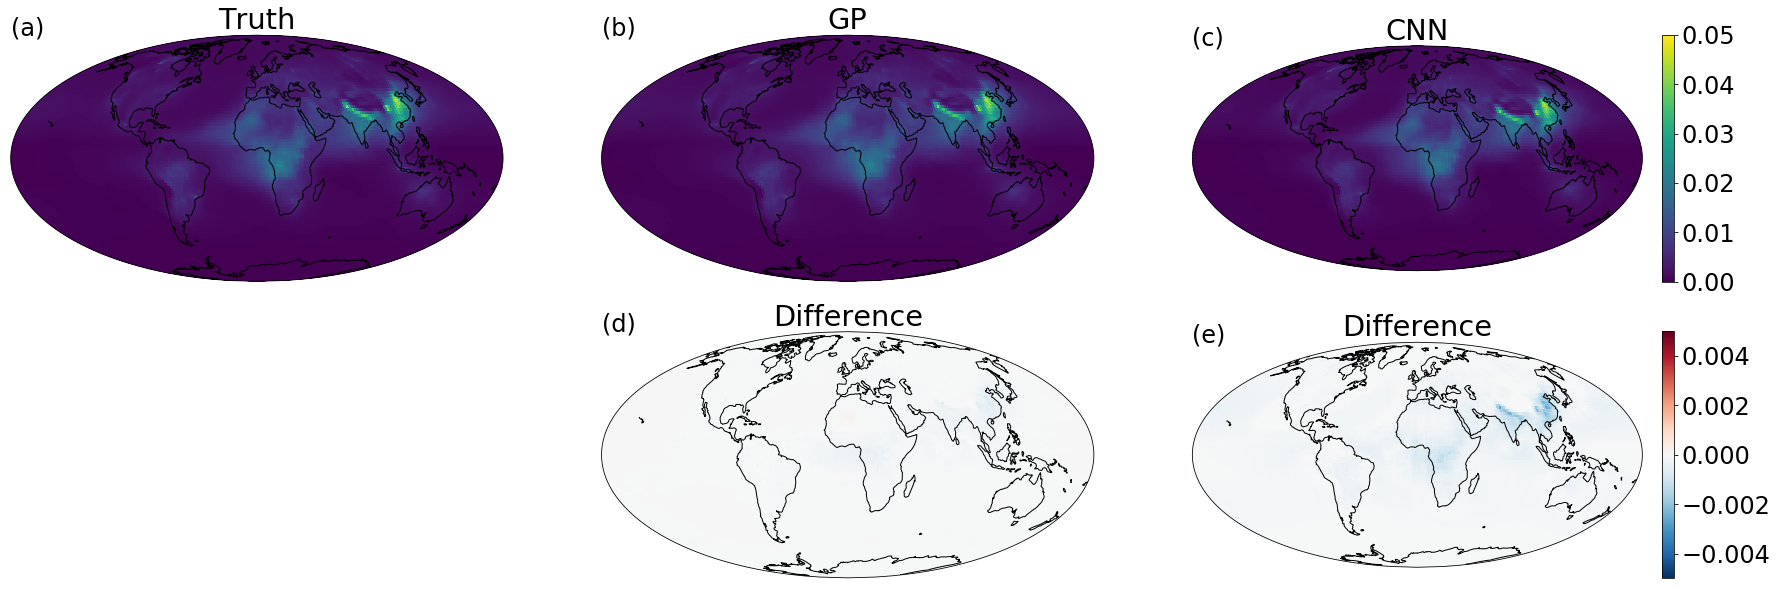

In [22]:
import matplotlib 
import cartopy.crs as ccrs
import iris.plot as iplt

plt.figure(figsize=(30, 10))
matplotlib.rcParams['font.size'] = 24

plt.subplot(2,3,1, projection=ccrs.Mollweide())
plt.annotate("(a)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh(Y_test[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('Truth')
plt.gca().coastlines()

plt.subplot(2,3,2, projection=ccrs.Mollweide())
plt.annotate("(b)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh(gp_prediction[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('GP')
plt.gca().coastlines()

plt.subplot(2,3,3, projection=ccrs.Mollweide())
plt.annotate("(c)", (0.,1.), xycoords='axes fraction')
im=iplt.pcolormesh(nn_prediction[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('CNN')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().coastlines()

plt.subplot(2,3,5, projection=ccrs.Mollweide())
plt.annotate("(d)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh((gp_prediction.collapsed(['sample', 'time'], iris.analysis.MEAN)-Y_test.collapsed(['job', 'time'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.005, vmax=0.005)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.subplot(2,3,6, projection=ccrs.Mollweide())
plt.annotate("(e)", (0.,1.), xycoords='axes fraction')
im=iplt.pcolormesh((nn_prediction.collapsed(['sample', 'time'], iris.analysis.MEAN)-Y_test.collapsed(['job', 'time'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.005, vmax=0.005)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.savefig('BCPPE_emulator_paper.png', transparent=True)

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1193: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
 

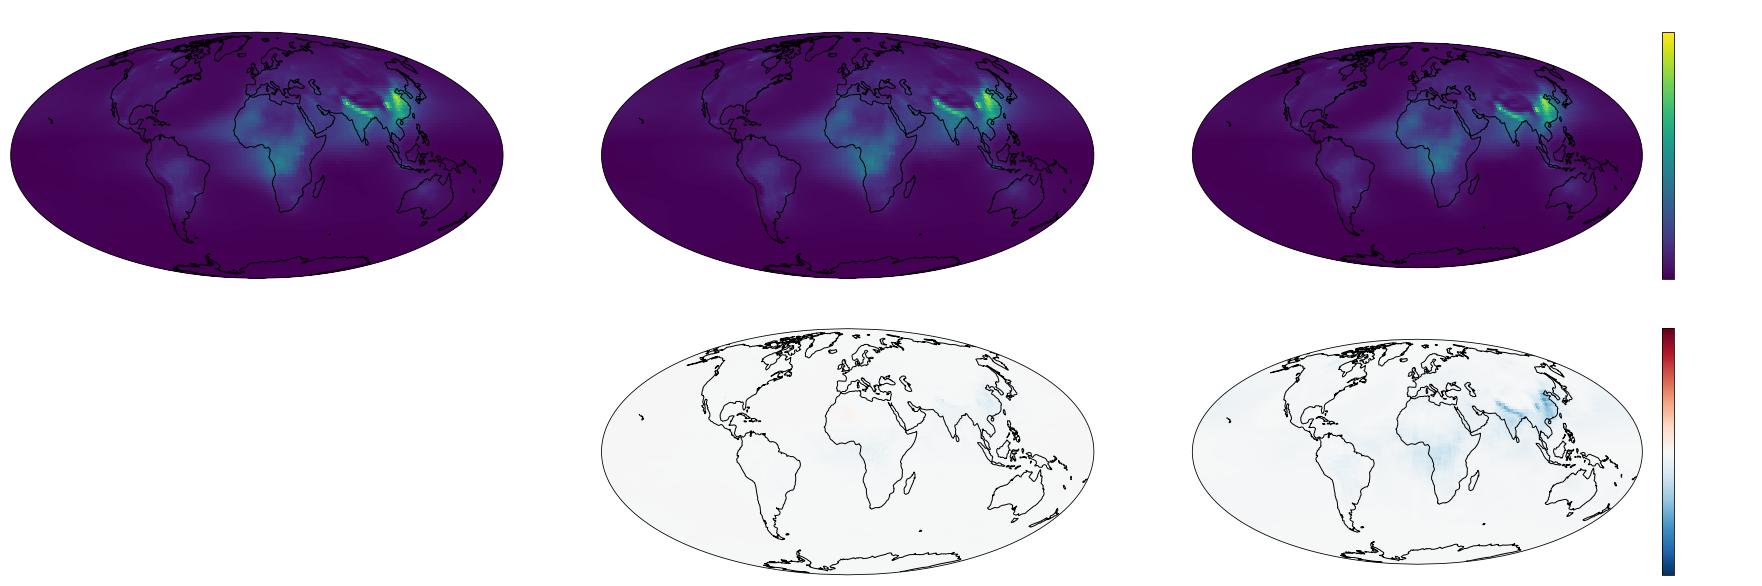

In [41]:

COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['font.size'] = 20

plt.figure(figsize=(30, 10))

plt.subplot(2,3,1, projection=ccrs.Mollweide())
iplt.pcolormesh(Y_test[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('Truth')
plt.gca().coastlines()

plt.subplot(2,3,2, projection=ccrs.Mollweide())
iplt.pcolormesh(gp_prediction[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('GP')
plt.gca().coastlines()

plt.subplot(2,3,3, projection=ccrs.Mollweide())
im=iplt.pcolormesh(nn_prediction[0].collapsed('time', iris.analysis.MEAN), vmin=0.0, vmax=0.05)
plt.gca().set_title('CNN')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().coastlines()

plt.subplot(2,3,5, projection=ccrs.Mollweide())
iplt.pcolormesh((gp_prediction.collapsed(['sample', 'time'], iris.analysis.MEAN)-Y_test.collapsed(['job', 'time'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.005, vmax=0.005)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.subplot(2,3,6, projection=ccrs.Mollweide())
im=iplt.pcolormesh((nn_prediction.collapsed(['sample', 'time'], iris.analysis.MEAN)-Y_test.collapsed(['job', 'time'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.005, vmax=0.005)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.savefig('BCPPE_emulator_talk.png', transparent=True)